In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import spacy
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

spacy_nlp = spacy.load("en_core_web_lg")

In [2]:
class NlpPipeline:
    
    class WrongOrderException(Exception):
        pass
    
    def __init__(self, df, text_column_name, target_name, clean_name='cleaned',
                 token_name='tokenized', nlp=spacy_nlp):
        """
        A pipeline for natural language processing
        
        [REQUIRED]
        df (DataFrame):
                The dataframe with the data
        
        [REQUIRED]
        text_column_name (str):
                The name of the column of documents
        
        [REQUIRED]
        target_name (str):
                The name of the target column
        
        [OPTIONAL] default: "cleaned"
        clean_name (str):
                The name of the column to store cleaned values in.
        
        [OPTIONAL] default: "tokenized"
        token_name (str):
                The name of the column to store tokenized values in.
                
        [OPTIONAL] default: spacy.load("en_core_web_lg")
        nlp (spacy model):
                A spacy language model for 
        """
        # Storing values
        self.container = df
        self.data_name = text_column_name
        self.target_name = target_name
        self.clean_name = clean_name
        self.token_name = token_name
        self.nlp = nlp
        
        col_names = df.columns.to_list()
        
        # Check if column names are already in dataframe
        if clean_name in col_names:
            print("WARNING: Value provided for parameter 'clean_name' is already a column.")
            
        if token_name in col_names:
            print("WARNING: Value provided for parameter 'token_name' is already a column.")
        
        
    def display(self):
        """ A function for displaying the dataframe """
        display(self.container)
        
        
    def Clean(self):
        """ A function for cleaning the dataframe's "text_col" and storing in the "clean_name" column. """
        
        self.container[self.clean_name] = self.container[self.data_name].apply(lambda x: BeautifulSoup(x).get_text()).apply(lambda x: re.sub(r'[^a-zA-Z ^0-9]', '', x))
        return self.container
    
    
    def Tokenize(self):
        """ A function for tokenizing the dataframe's "clean_col" and storing in the "token_name" column. """
        
        # Check that the required info exists. If not, throw exception
        if self.clean_name not in self.container.columns.to_list():
            raise NlpPipeline.WrongOrderException('Call .Clean() first!')
            
        self.container[self.token_name] = self.container[self.clean_name].apply(lambda x: [token.lemma_ for token in self.nlp(x) if (token.is_stop != True) and (token.is_punct != True)])
        return self.container
    
    
    def VectorizeCount(self):
        """ A function for vectorizing the dataframe's "token_name" and storing in the "word_count" var. """
        
        # Check that the required info exists. If not, throw exception
        if self.token_name not in self.container.columns.to_list():
            raise NlpPipeline.WrongOrderException('Call .Tokenize() first!')
            
        self.word_counts = Counter()
        self.container[self.token_name].apply(lambda x: self.word_counts.update(x))
        return self.word_counts
    
    
    def Vectorize(self, how='tfidf'):
        """
        A function for vectorizing the cleaned data and storing it as a dataframe
        
        [OPTIONAL] default: "tfidf"
        how (str): {"count", "tfidf"}
        """
        
        if self.clean_name not in self.container.columns.to_list():
            raise NlpPipeline.WrongOrderException('Call .Clean() first!')
        
        if how.lower() == 'count':
            self.vectorizer = CountVectorizer()
            
        elif how.lower() == 'tfidf':
            self.vectorizer = TfidfVectorizer(ngram_range=(1,2))
            
        dtm = self.vectorizer.fit_transform(self.container[self.clean_name].to_list())
        self.vectorized = pd.DataFrame(dtm.todense(), columns=self.vectorizer.get_feature_names())
            
        return self.vectorized
    
    
    def MakePipeline(self, steps, verbose=False):
        """
        A function for making the pipeline use in other functions
        
        [REQUIRED]
        steps (list):       
                List of (name, transform) tuples (implementing fit/transform)
                that are chained, in the order in which they are chained, with 
                the last object an estimator.
        
        [OPTIONAL] default: False
        verbose (boolean):  
                If True, the time elapsed while fitting each step will be
                printed as it is completed.
        """
        if hasattr(self, 'vectorizer') is False:
            raise NlpPipeline.WrongOrderException('Call .Vectorize() first!')
        self.pipeline = Pipeline(steps, verbose=verbose)
        return self.pipeline
    
    
    def GridSearchCV(self, parameters, cv=5, n_jobs=None, verbose=0, data_type='vectorized'):
        """
        A function for creating and fitting a GridSearchCV model.
        
        [REQUIRED]
        parameters (dict) or (list of dictionaries):
                Dictionary with parameters names (string) as keys and lists
                of parameter settings to try as values, or a list of such
                dictionaries, in which case the grids spanned by each
                dictionary in the list are explored. This enables searching
                over any sequence of parameter settings.
                
        [OPTIONAL] default: 5
        cv (int):
                Determines the cross-validation splitting strategy.
                
        [OPTIONAL] default: None
        n_jobs (int):
                Number of jobs to run in parallel.
                
        [OPTIONAL] default: 0
        verbose (boolean):
                Controls the verbosity: the higher, the more messages.
                
        [NOT IMPLEMENTED]
        data_type (str):
                Will be used to select data to use for fitting
        """
        
        # Check that the required info exists. If not, throw exception
        if hasattr(self, 'pipeline') is False:
            raise NlpPipeline.WrongOrderException("Call .MakePipeline() first!")
        
        # Check that the required info exists. If not, throw exception
        if hasattr(self, 'vectorized') is False:
            raise NlpPipeline.WrongOrderException("Call .Vectorize() first!")
            
        self.model = GridSearchCV(self.pipeline, parameters, cv=5, n_jobs=n_jobs, verbose=1)        
        self.model.fit(self.vectorized, self.container[self.target_name])
        
        return self.model
            
        
    def Predict(self, data):
        """
        Function to run a pandas series through the model to predict the target
        
        [REQUIRED]
        data (pandas Series):
                the data to run through the model to predict the target
                
        """
        
        #dtm = self.vectorizer.transform(data.to_list())
        #data = pd.DataFrame(dtm.todense(), columns=self.vectorizer.get_feature_names())
            
        # Check that the required info exists. If not, throw exception
        if hasattr(self, 'model') is False:
            raise NlpPipeline.WrongOrderException("Create a model first! \nEG: my_nlp.GridSearchCV()")
            
        vectors = pd.DataFrame(self.vectorizer.transform(data).todense(), columns=self.vectorizer.get_feature_names())

        return self.model.predict(vectors)

In [3]:
jobs = pd.read_csv('./module2-vector-representations/data/job_listings.csv')
jobs = jobs[jobs['title'] == 'Data Scientist'].drop(['title', jobs.columns.to_list()[0]], axis=1).reset_index().drop(['index'], axis=1)
jobs.head()

,description
0,"b'<div class=""jobsearch-JobMetadataHeader icl-..."
1,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...
2,b'<div>Create various Business Intelligence An...
3,"b""Everytown for Gun Safety, the nation's large..."
4,"b""nfosys\xe2\x80\x93 Data &amp; Analytics \xe2..."


In [4]:
#my_nlp = NlpPipeline(jobs, 'description', None)

In [5]:
#my_nlp.Tokenize()  # testing if exception works

In [6]:
#my_nlp.display()

In [7]:
#my_nlp.Clean()

In [8]:
#%%time
#my_nlp.Tokenize()

In [9]:
#my_nlp.VectorizeCount().most_common(10)

In [10]:
#my_nlp.Vectorize()

In [11]:
### DAY THREE

In [12]:
kaggle = pd.read_csv('./module3-document-classification/data/train.csv')
kaggle.head()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few lef...",1
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0
2,655,\nThis release is a port version of Amrut’s In...,1
3,555,\nThis 41 year old single cask was aged in a s...,1
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1


In [13]:
kaggle_pipeline = NlpPipeline(kaggle, 'description', 'ratingCategory')
kaggle_pipeline.display()

,id,description,ratingCategory
0,1321,"\nSometimes, when whisky is batched, a few lef...",1
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0
2,655,\nThis release is a port version of Amrut’s In...,1
3,555,\nThis 41 year old single cask was aged in a s...,1
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1
...,...,...,...
4082,3342,\nWhat lies beneath the surface of Dewar’s? He...,1
4083,3130,\nAfter 6 to 7 years of maturation in bourbon ...,1
4084,2811,"\nBright, delicate, and approachable. While no...",1
4085,478,\nI’m calling this the pitmaster’s dram: the n...,1


In [14]:
kaggle_pipeline.Clean()

,id,description,ratingCategory,cleaned
0,1321,"\nSometimes, when whisky is batched, a few lef...",1,Sometimes when whisky is batched a few leftove...
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0,An uncommon exclusive bottling of a 6 year old...
2,655,\nThis release is a port version of Amrut’s In...,1,This release is a port version of Amruts Inter...
3,555,\nThis 41 year old single cask was aged in a s...,1,This 41 year old single cask was aged in a she...
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1,Quite herbal on the nose with aromas of dried ...
...,...,...,...,...
4082,3342,\nWhat lies beneath the surface of Dewar’s? He...,1,What lies beneath the surface of Dewars Here t...
4083,3130,\nAfter 6 to 7 years of maturation in bourbon ...,1,After 6 to 7 years of maturation in bourbon ca...
4084,2811,"\nBright, delicate, and approachable. While no...",1,Bright delicate and approachable While not a s...
4085,478,\nI’m calling this the pitmaster’s dram: the n...,1,Im calling this the pitmasters dram the nose h...


In [15]:
%%time
kaggle_pipeline.Tokenize()

Wall time: 1min 2s


,id,description,ratingCategory,cleaned,tokenized
0,1321,"\nSometimes, when whisky is batched, a few lef...",1,Sometimes when whisky is batched a few leftove...,"[whisky, batch, leftover, barrel, return, ware..."
1,3861,\nAn uncommon exclusive bottling of a 6 year o...,0,An uncommon exclusive bottling of a 6 year old...,"[uncommon, exclusive, bottling, 6, year, old, ..."
2,655,\nThis release is a port version of Amrut’s In...,1,This release is a port version of Amruts Inter...,"[release, port, version, Amruts, Intermediate,..."
3,555,\nThis 41 year old single cask was aged in a s...,1,This 41 year old single cask was aged in a she...,"[41, year, old, single, cask, age, sherry, but..."
4,1965,"\nQuite herbal on the nose, with aromas of dri...",1,Quite herbal on the nose with aromas of dried ...,"[herbal, nose, aroma, dry, tarragon, parsley, ..."
...,...,...,...,...,...
4082,3342,\nWhat lies beneath the surface of Dewar’s? He...,1,What lies beneath the surface of Dewars Here t...,"[lie, beneath, surface, dewar, blend, finish, ..."
4083,3130,\nAfter 6 to 7 years of maturation in bourbon ...,1,After 6 to 7 years of maturation in bourbon ca...,"[6, 7, year, maturation, bourbon, cask, spend,..."
4084,2811,"\nBright, delicate, and approachable. While no...",1,Bright delicate and approachable While not a s...,"[bright, delicate, approachable, showstopper, ..."
4085,478,\nI’m calling this the pitmaster’s dram: the n...,1,Im calling this the pitmasters dram the nose h...,"[be, call, pitmaster, dram, nose, muscular, pe..."


In [16]:
kaggle_pipeline.VectorizeCount()

Counter({'whisky': 1658,
         'batch': 101,
         'leftover': 1,
         'barrel': 548,
         'return': 38,
         'warehouse': 48,
         'Canadian': 22,
         'Club': 12,
         'recently': 20,
         'pull': 47,
         'vat': 12,
         '1970s': 3,
         'Acetone': 1,
         'Granny': 3,
         'Smith': 6,
         'apple': 788,
         'freshcut': 26,
         'white': 346,
         'cedar': 96,
         'showcase': 23,
         'long': 551,
         'age': 646,
         'Complex': 24,
         'spicy': 685,
         'reserve': 6,
         'dram': 154,
         'ripe': 316,
         'strawberry': 132,
         'can': 13,
         'pear': 276,
         'clove': 369,
         'pepper': 903,
         'faint': 67,
         'flower': 107,
         'slightly': 341,
         'oak': 2072,
         'tannin': 143,
         'distinct': 30,
         'elegant': 102,
         'remarkably': 21,
         'vibrant': 81,
         'ancient': 11,
         'tired': 16,

In [17]:
kaggle_pipeline.Vectorize()

,005,005 but,005lower,005lower floor,006,006 are,08,08 masterclass,10,10 15,...,zone,zone not,zone the,zuidam,zuidam distillers,zuidam distillery,zuidam distillerys,zuidam dutch,zuidam in,zuidam uses
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4083,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
%%time
top_5k = [x for x in kaggle_pipeline.word_counts.most_common(6857) if x[0] in kaggle_pipeline.vectorized.columns.to_list()]
top_5k_words = [x[0] for x in top_5k]

Wall time: 53.1 s


In [26]:
display(top_5k)
top_5k_words

[('finish', 2923),
 ('fruit', 2127),
 ('oak', 2072),
 ('spice', 2060),
 ('note', 2048),
 ('palate', 1893),
 ('nose', 1847),
 ('sweet', 1757),
 ('vanilla', 1681),
 ('whisky', 1658),
 ('dry', 1466),
 ('year', 1336),
 ('chocolate', 1195),
 ('cask', 1092),
 ('old', 1078),
 ('smoke', 1013),
 ('malt', 1001),
 ('flavor', 980),
 ('orange', 969),
 ('whiskey', 950),
 ('pepper', 903),
 ('caramel', 884),
 ('hint', 878),
 ('cinnamon', 852),
 ('bottle', 821),
 ('bourbon', 810),
 ('apple', 788),
 ('sherry', 784),
 ('toffee', 740),
 ('honey', 732),
 ('spicy', 685),
 ('dark', 685),
 ('age', 646),
 ('light', 639),
 ('rye', 636),
 ('citrus', 607),
 ('like', 597),
 ('soft', 591),
 ('ginger', 572),
 ('peat', 557),
 ('mature', 557),
 ('sweetness', 552),
 ('long', 551),
 ('barrel', 548),
 ('candy', 542),
 ('aroma', 537),
 ('release', 524),
 ('balance', 515),
 ('fresh', 513),
 ('lemon', 509),
 ('rich', 501),
 ('wood', 480),
 ('good', 474),
 ('black', 461),
 ('water', 460),
 ('distillery', 435),
 ('grain', 431

['finish',
 'fruit',
 'oak',
 'spice',
 'note',
 'palate',
 'nose',
 'sweet',
 'vanilla',
 'whisky',
 'dry',
 'year',
 'chocolate',
 'cask',
 'old',
 'smoke',
 'malt',
 'flavor',
 'orange',
 'whiskey',
 'pepper',
 'caramel',
 'hint',
 'cinnamon',
 'bottle',
 'bourbon',
 'apple',
 'sherry',
 'toffee',
 'honey',
 'spicy',
 'dark',
 'age',
 'light',
 'rye',
 'citrus',
 'like',
 'soft',
 'ginger',
 'peat',
 'mature',
 'sweetness',
 'long',
 'barrel',
 'candy',
 'aroma',
 'release',
 'balance',
 'fresh',
 'lemon',
 'rich',
 'wood',
 'good',
 'black',
 'water',
 'distillery',
 'grain',
 'creamy',
 'cherry',
 'single',
 'fruity',
 'leather',
 'new',
 'sugar',
 'corn',
 'clove',
 'blend',
 'hot',
 'peach',
 'peel',
 'white',
 'slightly',
 'not',
 'red',
 'expression',
 'add',
 'offer',
 'floral',
 'clean',
 'mint',
 'almond',
 'subtle',
 'ripe',
 'licorice',
 'green',
 'warm',
 'bottling',
 'barley',
 'little',
 'bit',
 'syrup',
 'cream',
 'show',
 'taste',
 'complex',
 'cocoa',
 'milk',
 'gre

In [20]:
kaggle_pipeline.vectorized = kaggle_pipeline.vectorized[top_5k_words]
kaggle_pipeline.vectorized

,finish,fruit,oak,spice,note,palate,nose,sweet,vanilla,whisky,...,twang,finish100,280,scorched,exclusive36,identifiable,gelato,tasmanian,mashup,bitterly
0,0.000000,0.000000,0.023864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.020150,0.000000,0.000000,0.000000,0.000000,0.000000,0.024520,0.027517,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.025267,0.000000,0.000000,0.000000,0.023646,0.000000,0.000000,0.031065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.023175,0.000000,0.030134,0.000000,0.000000,0.027699,0.028201,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.023691,0.000000,0.000000,0.000000,0.055941,0.028316,0.028829,0.032353,0.031398,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082,0.000000,0.000000,0.000000,0.000000,0.046612,0.000000,0.000000,0.053915,0.052324,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4083,0.027849,0.000000,0.000000,0.000000,0.065757,0.033285,0.033888,0.000000,0.073815,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4084,0.000000,0.034077,0.000000,0.037842,0.000000,0.027891,0.000000,0.031868,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4085,0.000000,0.030543,0.000000,0.000000,0.000000,0.024999,0.025452,0.028563,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
wc = pd.DataFrame(top_5k, columns=['word', 'count'])
display(wc.dtypes)
graph = wc[wc['count'] >= 1000]
display(graph)

word     object
count     int64
dtype: object

,word,count
0,finish,2923
1,fruit,2127
2,oak,2072
3,spice,2060
4,note,2048
5,palate,1893
6,nose,1847
7,sweet,1757
8,vanilla,1681
9,whisky,1658


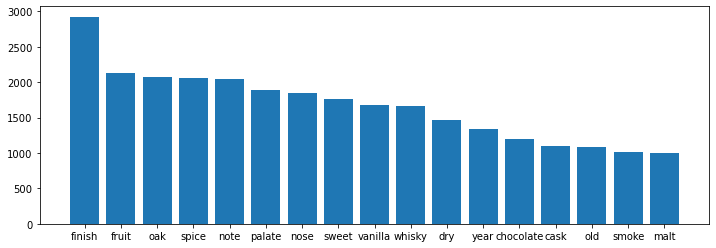

In [22]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 12, 4

plt.bar(graph['word'], graph['count']);

In [23]:
test = pd.read_csv('./module3-document-classification/data/test.csv')
test.shape

(1022, 2)

In [24]:
clf = RandomForestClassifier()

kaggle_pipeline.MakePipeline([
        ('clf', clf)
    ])

parameters = {
    'clf__max_depth':(5,10,15,20)
}

In [33]:
kaggle_pipeline.pipeline = Pipeline([('clf', clf)], verbose=1)

In [36]:
%%time
import pickle

kaggle_pipeline.GridSearchCV(parameters, n_jobs=2)

pickle.dump(kaggle_pipeline, open("kaggle_pipeline.pkl", "wb"))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   30.5s finished


[Pipeline] ............... (step 1 of 1) Processing clf, total=   4.5s
Wall time: 1min 1s


In [37]:
display(kaggle_pipeline.vectorized.head())
display(test['description'].head())
test_transformed = pd.DataFrame(kaggle_pipeline.vectorizer.transform(test['description']).todense(), columns=kaggle_pipeline.vectorizer.get_feature_names())[top_5k_words]
display(test_transformed)

,finish,fruit,oak,spice,note,palate,nose,sweet,vanilla,whisky,...,twang,finish100,280,scorched,exclusive36,identifiable,gelato,tasmanian,mashup,bitterly
0,0.000000,0.0,0.023864,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.029340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.020150,0.0,0.000000,0.0,0.000000,0.000000,0.024520,0.027517,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.025267,0.0,0.000000,0.000000,0.023646,0.000000,0.000000,0.031065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.023175,0.0,0.030134,0.0,0.000000,0.027699,0.028201,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.023691,0.0,0.000000,0.0,0.055941,0.028316,0.028829,0.032353,0.031398,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


0    \nStyle: Speyside single malt scotch Color: Wa...
1    \nVery bright and lively, with a nice balance ...
2    \nA new oloroso-forward Chivas positioned to s...
3    \nAged in bourbon casks and then enhanced in R...
4    \nThere is a freshness to the wood on the nose...
Name: description, dtype: object

,finish,fruit,oak,spice,note,palate,nose,sweet,vanilla,whisky,...,twang,finish100,280,scorched,exclusive36,identifiable,gelato,tasmanian,mashup,bitterly
0,0.026669,0.000000,0.034678,0.043247,0.000000,0.031875,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.020820,0.030403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027593,0.033284,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.023932,0.000000,0.000000,0.000000,0.056508,0.000000,0.029122,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.040660,0.000000,0.052870,0.000000,0.000000,0.000000,0.000000,0.000000,0.053886,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.029486,0.000000,0.000000,0.047814,0.000000,0.035242,0.035881,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,0.024826,0.000000,0.000000,0.040257,0.000000,0.000000,0.030209,0.000000,0.032901,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1018,0.037194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049293,0.118921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1019,0.026427,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1020,0.030161,0.044043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039972,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
y_pred = kaggle_pipeline.Predict(test_transformed)
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [46]:
pd.Series(y_pred)

0       1
1       1
2       1
3       1
4       1
       ..
1017    1
1018    1
1019    1
1020    1
1021    1
Length: 1022, dtype: int64

In [55]:
test_ids = pd.read_csv('./module3-document-classification/data/test.csv')['id'].to_list()
print(len(test_ids))
print(len(y_pred))

1022
1022


In [61]:
kaggle_submission = pd.DataFrame([test_ids, y_pred]).T.rename({0:'id', 1:'ratingCategory'}, axis=1)
kaggle_submission

,id,ratingCategory
0,3461,1
1,2604,1
2,3341,1
3,3764,1
4,2306,1
...,...,...
1017,2853,1
1018,219,1
1019,1286,1
1020,2201,1
